In [1]:
!pip install opendatasets

In [2]:
import os
from glob import glob
from PIL import Image
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import opendatasets as od
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import JaccardIndex, Accuracy

In [3]:
od.download('https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ryankim17920


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset


100%|██████████| 195M/195M [00:02<00:00, 102MB/s]  


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        image = np.array(image)
        mask = np.array(mask)

        # Determine the class from the directory name
        class_name = os.path.basename(os.path.dirname(self.image_paths[idx]))
        if class_name == 'benign':
            mask[mask > 0] = 1
        elif class_name == 'malignant':
            mask[mask > 0] = 2
        elif class_name == 'normal':
            mask[mask > 0] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

def get_file_paths(root_dir):
    image_paths = []
    mask_paths = []

    for class_dir in ['benign', 'malignant', 'normal']:
        class_path = os.path.join(root_dir, class_dir)
        images = glob(os.path.join(class_path, '*.png'))
        for img in images:
            if '_mask' not in img:
                mask = img.replace('.png', '_mask.png')
                if os.path.exists(mask):
                    image_paths.append(img)
                    mask_paths.append(mask)

    return image_paths, mask_paths

root_dir = 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
image_paths, mask_paths = get_file_paths(root_dir)

In [5]:
image_paths

['breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (282).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (420).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (221).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (257).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (195).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (281).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (88).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (258).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (333).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (320).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (105).png',
 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (260).png',
 'breast-ultrasou

In [6]:
from sklearn.model_selection import StratifiedKFold

def stratified_k_fold_split(image_paths, mask_paths, n_splits=5):
    labels = [os.path.basename(img).split(' ')[0] for img in image_paths]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = list(skf.split(image_paths, labels))
    return splits

splits = stratified_k_fold_split(image_paths, mask_paths)

In [7]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=360, shift_limit=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [8]:
def create_dataloaders(image_paths, mask_paths, splits, fold_idx, transform, batch_size=8):
    train_idx, val_idx = splits[fold_idx]
    train_images = [image_paths[i] for i in train_idx]
    train_masks = [mask_paths[i] for i in train_idx]
    val_images = [image_paths[i] for i in val_idx]
    val_masks = [mask_paths[i] for i in val_idx]

    train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
    val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader


fold_idx = 0 
batch_size = 8
train_loader, val_loader = create_dataloaders(image_paths, mask_paths, splits, fold_idx, transform, batch_size)


In [9]:
for x,y in train_loader:
    print(x[0].shape, y[0][None].shape)
    break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


In [10]:
def plot_image_and_feature_map(img, feature_map):
    """
    Plots the given image and feature map side by side.

    Parameters:
    img (torch.Tensor): The image with shape (3, 500, 500).
    feature_map (torch.Tensor): The feature map with shape (1, 500, 500).
    """
    # Convert the image from (3, 500, 500) to (500, 500, 3) for visualization
    img_transposed = img.permute(1, 2, 0).numpy()

    # Convert the feature map to numpy array
    feature_map_np = feature_map[0].numpy()

    # Create the subplots
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))

    # Plot the image
    axs[0].imshow(img_transposed)
    axs[0].set_title('Image')
    axs[0].axis('off')

    # Plot the feature map
    axs[1].imshow(feature_map_np, cmap='gray')
    axs[1].set_title('Feature Map')
    axs[1].axis('off')

    # Display the plots
    plt.show()
def plot_image_feature_preds(img, feature_map, preds):
    """
    Plots the given image and feature map side by side.

    Parameters:
    img (torch.Tensor): The image with shape (3, 500, 500).
    feature_map (torch.Tensor): The feature map with shape (1, 500, 500).
    """
    # Convert the image from (3, 500, 500) to (500, 500, 3) for visualization
    img_transposed = img.permute(1, 2, 0).numpy()

    # Convert the feature map to numpy array
    feature_map_np = feature_map[0].numpy()
    preds_np = preds[0].numpy()
    
    # Create the subplots
    fig, axs = plt.subplots(1, 3, figsize=(4, 2))

    # Plot the image
    axs[0].imshow(img_transposed)
    axs[0].set_title('Image')
    axs[0].axis('off')

    # Plot the feature map
    axs[1].imshow(feature_map_np, cmap='viridis')
    axs[1].set_title('Feature Map')
    axs[1].axis('off')

    axs[2].imshow(preds_np, cmap='viridis')
    axs[2].set_title('Pred Map')
    axs[2].axis('off')

    # Display the plots
    plt.show()

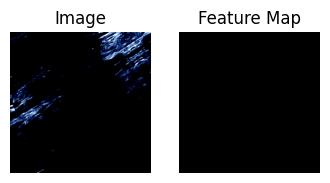

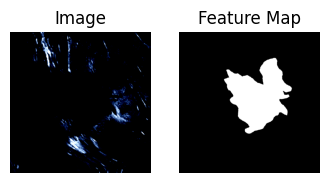

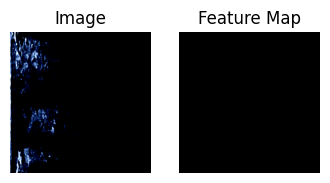

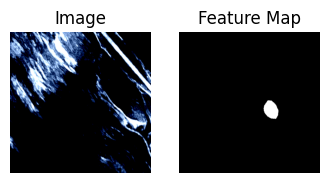

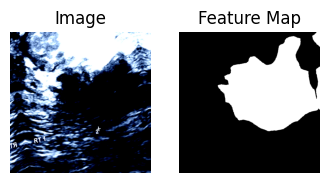

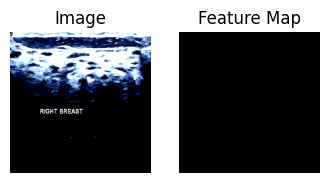

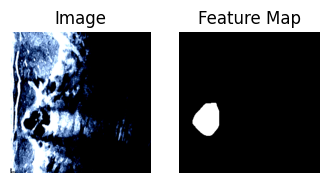

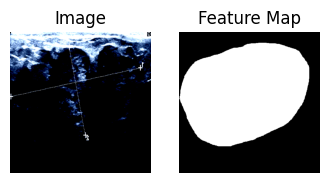

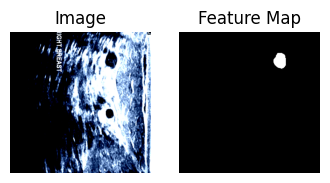

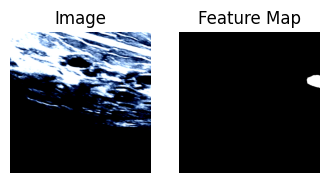

In [11]:
load = iter(train_loader)
for _ in range(10):
    x, y = next(load)
    plot_image_and_feature_map(x[0], y[0][None])

In [12]:
class SE(nn.Module):
    # Squeeze and Excitation block
    def __init__(self, channels, reduct=4):
        super(SE, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.layers = nn.Sequential(
            nn.Linear(channels, channels // reduct),
            nn.ReLU(),
            nn.Linear(channels // reduct, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        pooled = self.pool(x).view(batch_size, channels)
        scale = self.layers(pooled).view(batch_size, channels, 1, 1)
        return x * scale.expand_as(x)


class BottleNeck(nn.Module):
    # BottleNeck roughly based on MobileNetV3 Architecture
    def __init__(self, in_channels, out_channels, internal_dim, down_sample=True, no_sample=False, kernel_size=3, stride=1, activation=nn.ReLU(), se=False):
        super(BottleNeck, self).__init__()
        self.res = (in_channels == out_channels)
        self.no_sample = no_sample
        
        self.se_layer = SE(internal_dim) if se else nn.Identity()
        
        self.upsample = nn.Identity() if down_sample else nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.downsample = nn.MaxPool2d(2) if down_sample else nn.Identity()
        self.down_sample = down_sample
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, internal_dim, kernel_size=1),
            nn.BatchNorm2d(internal_dim),
            activation,
            nn.Conv2d(internal_dim, internal_dim, kernel_size=kernel_size, stride=stride, padding=kernel_size//2),
            nn.BatchNorm2d(internal_dim),
            self.se_layer,
            activation,
            nn.Conv2d(internal_dim, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        if self.no_sample:
            return self.layers(x)
        if self.res:
            return x + self.layers(x)
        elif self.down_sample:
            return self.downsample(self.layers(x))
        return self.layers(self.upsample(x))

class seg_model(nn.Module):
    def __init__(self):
        super(seg_model, self).__init__()
        self.enc = nn.ModuleList([
            BottleNeck(3, 16, 16, True), 
            BottleNeck(16, 24, 32, True), 
            BottleNeck(24, 48, 64, True),
            BottleNeck(48, 96, 128, True),
            BottleNeck(96, 192, 256, True)
        ])
        self.mid_layer = nn.Sequential(BottleNeck(192, 192, 256), BottleNeck(192, 192, 256))
        self.dec = nn.ModuleList([
            BottleNeck(192 + 192, 96, 256, False),
            BottleNeck(96 + 96, 48, 128, False),
            BottleNeck(48 + 48, 24, 64, False),
            BottleNeck(24 + 24, 16, 32, False),
            BottleNeck(16 + 16, 3, 16, False),
        ])
        self.to_logits = BottleNeck(3, 3, 8)

    def forward(self, x):
        enc_outputs = []
        for layer in self.enc:
            x = layer(x)
            enc_outputs.append(x)
        x = self.mid_layer(x)
        for i, layer in enumerate(self.dec):
            x = torch.cat((x, enc_outputs[len(enc_outputs) - i - 1]), dim=1)
            x = layer(x)
        return self.to_logits(x)

In [13]:
num_epochs = 500
learning_rate = 0.001

model = seg_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(sum(p.numel() for p in model.parameters()))

4010578


In [14]:
device

device(type='cuda')

100%|██████████| 78/78 [00:25<00:00,  3.12it/s]


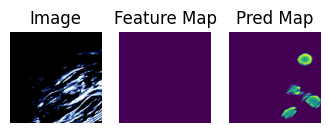

Epoch [1/500], Loss: 1.0241, JaccardIndex: 0.2784


100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


Validation Loss: 1.0827, Validation JaccardIndex: 0.2769


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


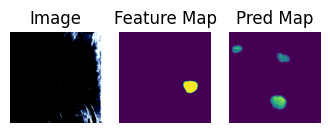

Epoch [2/500], Loss: 0.8556, JaccardIndex: 0.3374


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Validation Loss: 0.9099, Validation JaccardIndex: 0.2759


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


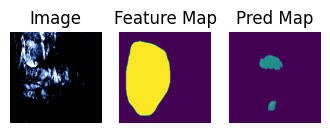

Epoch [3/500], Loss: 0.7300, JaccardIndex: 0.3323


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Validation Loss: 0.6648, Validation JaccardIndex: 0.3502


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


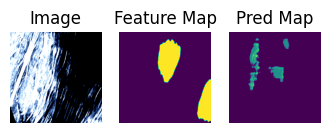

Epoch [4/500], Loss: 0.6213, JaccardIndex: 0.3726


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Validation Loss: 0.6017, Validation JaccardIndex: 0.3447


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


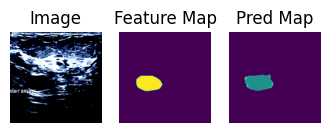

Epoch [5/500], Loss: 0.5383, JaccardIndex: 0.3793


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Validation Loss: 0.4960, Validation JaccardIndex: 0.4286


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


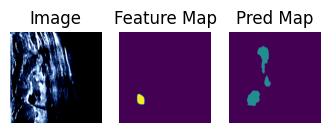

Epoch [6/500], Loss: 0.4797, JaccardIndex: 0.3870


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Validation Loss: 0.4526, Validation JaccardIndex: 0.3773


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


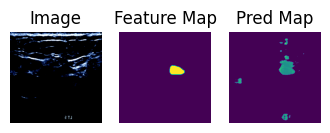

Epoch [7/500], Loss: 0.4286, JaccardIndex: 0.3970


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Validation Loss: 0.4126, Validation JaccardIndex: 0.3834


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


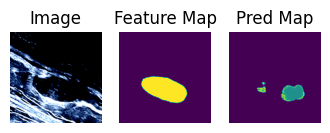

Epoch [8/500], Loss: 0.3959, JaccardIndex: 0.3971


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Validation Loss: 0.4976, Validation JaccardIndex: 0.3629


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


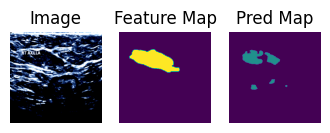

Epoch [9/500], Loss: 0.3667, JaccardIndex: 0.4018


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Validation Loss: 0.3621, Validation JaccardIndex: 0.4279


100%|██████████| 78/78 [00:23<00:00,  3.31it/s]


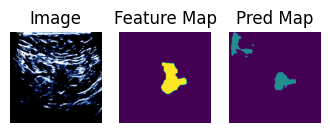

Epoch [10/500], Loss: 0.3449, JaccardIndex: 0.4093


100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


Validation Loss: 0.4167, Validation JaccardIndex: 0.3672


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


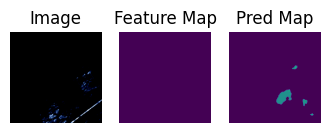

Epoch [11/500], Loss: 0.3266, JaccardIndex: 0.4107


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Validation Loss: 0.3356, Validation JaccardIndex: 0.4102


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


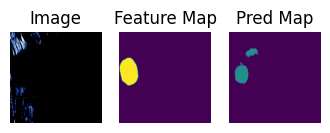

Epoch [12/500], Loss: 0.3131, JaccardIndex: 0.4020


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Validation Loss: 0.3178, Validation JaccardIndex: 0.3817


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


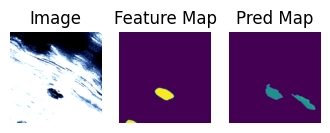

Epoch [13/500], Loss: 0.2997, JaccardIndex: 0.4105


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Validation Loss: 0.3174, Validation JaccardIndex: 0.4259


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


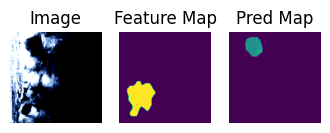

Epoch [14/500], Loss: 0.2877, JaccardIndex: 0.4090


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Validation Loss: 0.2758, Validation JaccardIndex: 0.4492


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


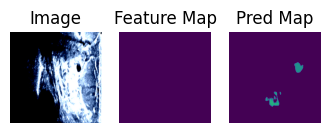

Epoch [15/500], Loss: 0.2858, JaccardIndex: 0.4116


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Validation Loss: 0.2991, Validation JaccardIndex: 0.4436


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


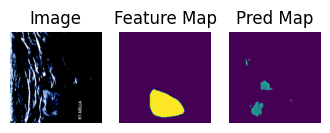

Epoch [16/500], Loss: 0.2754, JaccardIndex: 0.4126


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Validation Loss: 0.2664, Validation JaccardIndex: 0.4817


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


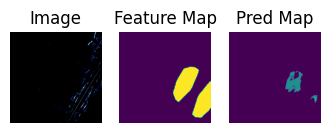

Epoch [17/500], Loss: 0.2677, JaccardIndex: 0.4223


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Validation Loss: 0.2733, Validation JaccardIndex: 0.4080


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


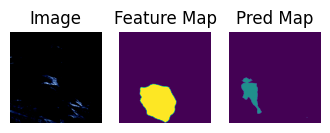

Epoch [18/500], Loss: 0.2661, JaccardIndex: 0.4032


100%|██████████| 20/20 [00:03<00:00,  5.53it/s]


Validation Loss: 0.2631, Validation JaccardIndex: 0.4483


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


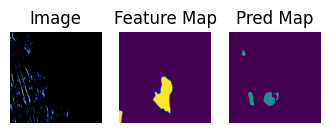

Epoch [19/500], Loss: 0.2559, JaccardIndex: 0.4108


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Validation Loss: 0.2659, Validation JaccardIndex: 0.4263


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


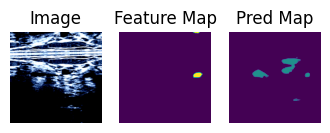

Epoch [20/500], Loss: 0.2559, JaccardIndex: 0.4160


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Validation Loss: 0.2628, Validation JaccardIndex: 0.4221


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


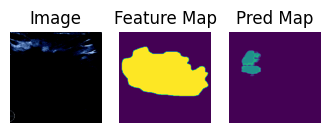

Epoch [21/500], Loss: 0.2536, JaccardIndex: 0.4153


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Validation Loss: 0.2512, Validation JaccardIndex: 0.3969


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


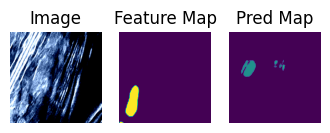

Epoch [22/500], Loss: 0.2516, JaccardIndex: 0.4133


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Validation Loss: 0.2518, Validation JaccardIndex: 0.4242


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


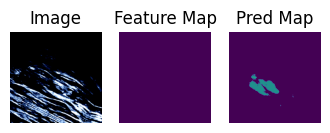

Epoch [23/500], Loss: 0.2427, JaccardIndex: 0.4159


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Validation Loss: 0.2704, Validation JaccardIndex: 0.3886


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


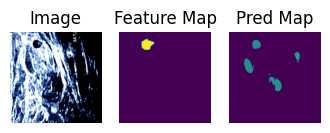

Epoch [24/500], Loss: 0.2426, JaccardIndex: 0.4095


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Validation Loss: 0.2573, Validation JaccardIndex: 0.4002


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


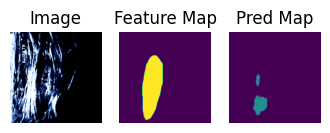

Epoch [25/500], Loss: 0.2412, JaccardIndex: 0.4224


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Validation Loss: 0.2472, Validation JaccardIndex: 0.4467


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


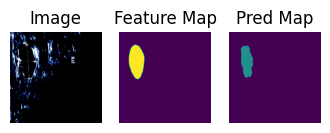

Epoch [26/500], Loss: 0.2399, JaccardIndex: 0.4222


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Validation Loss: 0.3139, Validation JaccardIndex: 0.3859


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


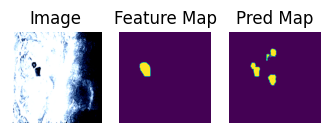

Epoch [27/500], Loss: 0.2389, JaccardIndex: 0.4106


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Validation Loss: 0.2333, Validation JaccardIndex: 0.5782


100%|██████████| 78/78 [00:23<00:00,  3.31it/s]


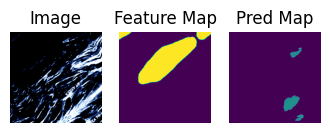

Epoch [28/500], Loss: 0.2413, JaccardIndex: 0.4152


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Validation Loss: 0.2392, Validation JaccardIndex: 0.4322


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


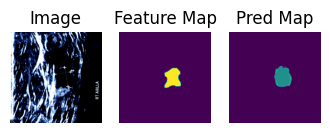

Epoch [29/500], Loss: 0.2395, JaccardIndex: 0.4098


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Validation Loss: 0.2761, Validation JaccardIndex: 0.3882


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


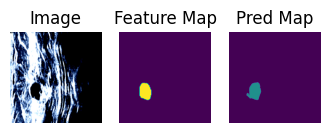

Epoch [30/500], Loss: 0.2329, JaccardIndex: 0.4109


100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


Validation Loss: 0.2446, Validation JaccardIndex: 0.4074


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


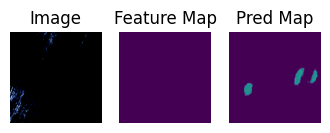

Epoch [31/500], Loss: 0.2315, JaccardIndex: 0.4136


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Validation Loss: 0.2292, Validation JaccardIndex: 0.4835


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


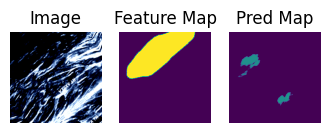

Epoch [32/500], Loss: 0.2362, JaccardIndex: 0.4132


100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Validation Loss: 0.2350, Validation JaccardIndex: 0.3858


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


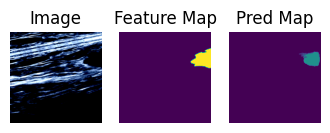

Epoch [33/500], Loss: 0.2343, JaccardIndex: 0.4128


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Validation Loss: 0.2321, Validation JaccardIndex: 0.4060


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


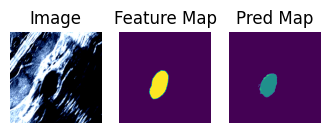

Epoch [34/500], Loss: 0.2318, JaccardIndex: 0.4129


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Validation Loss: 0.2270, Validation JaccardIndex: 0.4821


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


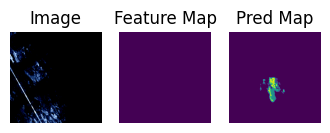

Epoch [35/500], Loss: 0.2279, JaccardIndex: 0.4123


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Validation Loss: 0.2360, Validation JaccardIndex: 0.4008


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


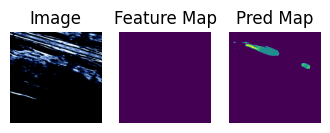

Epoch [36/500], Loss: 0.2284, JaccardIndex: 0.4217


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Validation Loss: 0.2230, Validation JaccardIndex: 0.4029


100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


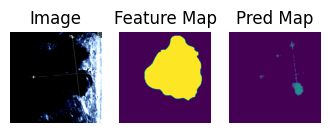

Epoch [37/500], Loss: 0.2229, JaccardIndex: 0.4208


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Validation Loss: 0.2255, Validation JaccardIndex: 0.4537


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


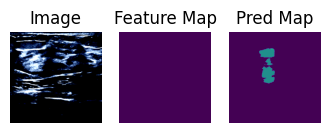

Epoch [38/500], Loss: 0.2260, JaccardIndex: 0.4235


100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Validation Loss: 0.2278, Validation JaccardIndex: 0.4572


100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


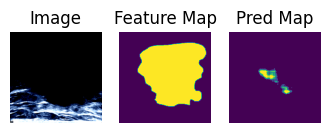

Epoch [39/500], Loss: 0.2276, JaccardIndex: 0.4228


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Validation Loss: 0.2309, Validation JaccardIndex: 0.4095


100%|██████████| 78/78 [00:23<00:00,  3.25it/s]


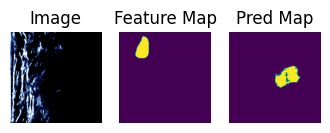

Epoch [40/500], Loss: 0.2248, JaccardIndex: 0.4233


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Validation Loss: 0.2383, Validation JaccardIndex: 0.4104


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


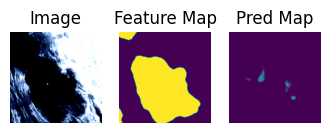

Epoch [41/500], Loss: 0.2270, JaccardIndex: 0.4205


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Validation Loss: 0.2387, Validation JaccardIndex: 0.3919


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


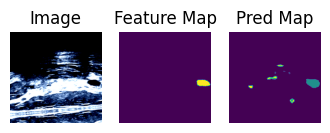

Epoch [42/500], Loss: 0.2252, JaccardIndex: 0.4227


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Validation Loss: 0.2191, Validation JaccardIndex: 0.4428


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


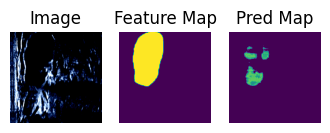

Epoch [43/500], Loss: 0.2169, JaccardIndex: 0.4356


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Validation Loss: 0.2157, Validation JaccardIndex: 0.4130


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


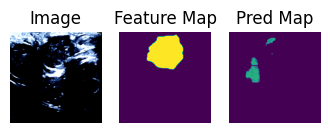

Epoch [44/500], Loss: 0.2205, JaccardIndex: 0.4291


100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Validation Loss: 0.2152, Validation JaccardIndex: 0.4448


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


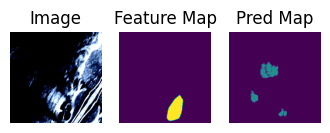

Epoch [45/500], Loss: 0.2219, JaccardIndex: 0.4269


100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Validation Loss: 0.2314, Validation JaccardIndex: 0.4026


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


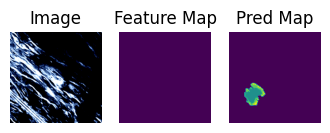

Epoch [46/500], Loss: 0.2208, JaccardIndex: 0.4277


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Validation Loss: 0.2274, Validation JaccardIndex: 0.4078


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


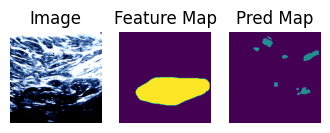

Epoch [47/500], Loss: 0.2182, JaccardIndex: 0.4233


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Validation Loss: 0.2178, Validation JaccardIndex: 0.4772


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


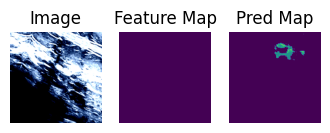

Epoch [48/500], Loss: 0.2211, JaccardIndex: 0.4176


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


Validation Loss: 0.2154, Validation JaccardIndex: 0.4418


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


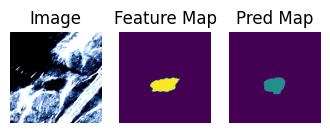

Epoch [49/500], Loss: 0.2195, JaccardIndex: 0.4265


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Validation Loss: 0.2190, Validation JaccardIndex: 0.4596


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


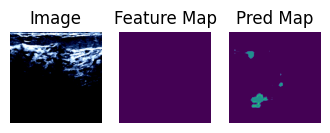

Epoch [50/500], Loss: 0.2219, JaccardIndex: 0.4277


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Validation Loss: 0.2136, Validation JaccardIndex: 0.4371


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


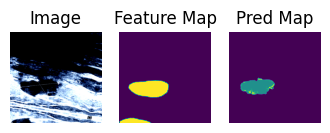

Epoch [51/500], Loss: 0.2195, JaccardIndex: 0.4298


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Validation Loss: 0.2134, Validation JaccardIndex: 0.4459


100%|██████████| 78/78 [00:23<00:00,  3.31it/s]


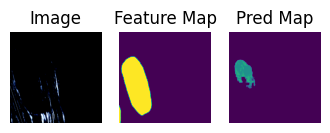

Epoch [52/500], Loss: 0.2146, JaccardIndex: 0.4287


100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


Validation Loss: 0.2211, Validation JaccardIndex: 0.4308


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


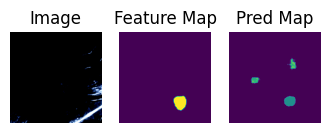

Epoch [53/500], Loss: 0.2195, JaccardIndex: 0.4307


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Validation Loss: 0.2091, Validation JaccardIndex: 0.4174


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


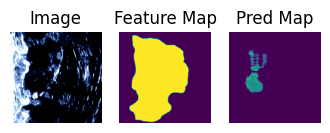

Epoch [54/500], Loss: 0.2145, JaccardIndex: 0.4325


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Validation Loss: 0.2325, Validation JaccardIndex: 0.4872


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


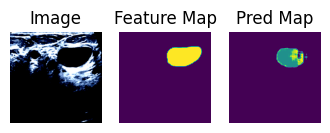

Epoch [55/500], Loss: 0.2123, JaccardIndex: 0.4414


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Validation Loss: 0.2253, Validation JaccardIndex: 0.4499


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


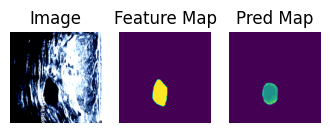

Epoch [56/500], Loss: 0.2140, JaccardIndex: 0.4409


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Validation Loss: 0.2095, Validation JaccardIndex: 0.4376


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


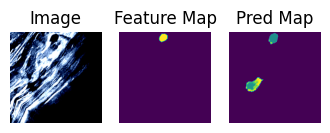

Epoch [57/500], Loss: 0.2155, JaccardIndex: 0.4321


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Validation Loss: 0.2108, Validation JaccardIndex: 0.4496


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


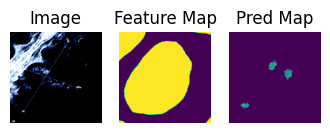

Epoch [58/500], Loss: 0.2135, JaccardIndex: 0.4480


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


Validation Loss: 0.2099, Validation JaccardIndex: 0.4582


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


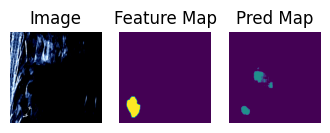

Epoch [59/500], Loss: 0.2245, JaccardIndex: 0.4259


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Validation Loss: 0.2075, Validation JaccardIndex: 0.6022


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


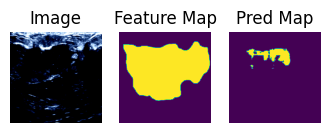

Epoch [60/500], Loss: 0.2128, JaccardIndex: 0.4292


100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Validation Loss: 0.2124, Validation JaccardIndex: 0.4668


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


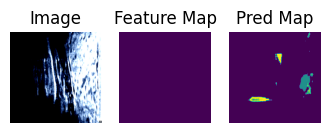

Epoch [61/500], Loss: 0.2160, JaccardIndex: 0.4319


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Validation Loss: 0.2096, Validation JaccardIndex: 0.4438


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


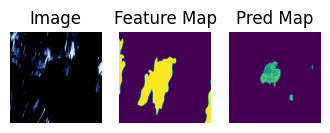

Epoch [62/500], Loss: 0.2132, JaccardIndex: 0.4411


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Validation Loss: 0.2067, Validation JaccardIndex: 0.4164


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


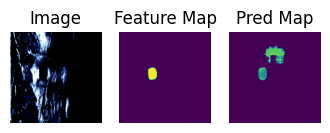

Epoch [63/500], Loss: 0.2133, JaccardIndex: 0.4346


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Validation Loss: 0.2220, Validation JaccardIndex: 0.3957


100%|██████████| 78/78 [00:23<00:00,  3.29it/s]


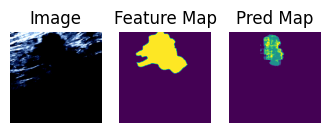

Epoch [64/500], Loss: 0.2112, JaccardIndex: 0.4476


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Validation Loss: 0.2114, Validation JaccardIndex: 0.4453


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


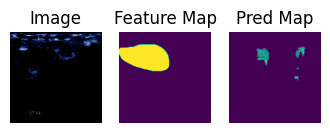

Epoch [65/500], Loss: 0.2116, JaccardIndex: 0.4413


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Validation Loss: 0.2068, Validation JaccardIndex: 0.4363


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


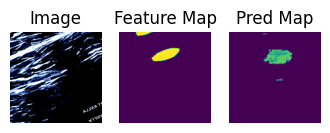

Epoch [66/500], Loss: 0.2078, JaccardIndex: 0.4534


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Validation Loss: 0.1973, Validation JaccardIndex: 0.4559


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


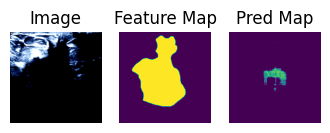

Epoch [67/500], Loss: 0.2100, JaccardIndex: 0.4557


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Validation Loss: 0.2092, Validation JaccardIndex: 0.4892


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


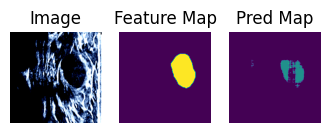

Epoch [68/500], Loss: 0.2068, JaccardIndex: 0.4503


100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Validation Loss: 0.2423, Validation JaccardIndex: 0.5611


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


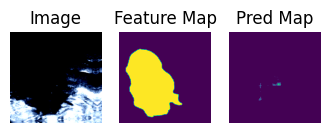

Epoch [69/500], Loss: 0.2133, JaccardIndex: 0.4353


100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Validation Loss: 0.2162, Validation JaccardIndex: 0.4611


100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


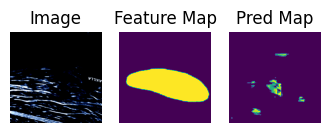

Epoch [70/500], Loss: 0.2117, JaccardIndex: 0.4484


100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Validation Loss: 0.2287, Validation JaccardIndex: 0.4501


100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


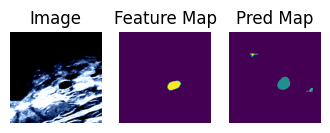

Epoch [71/500], Loss: 0.2127, JaccardIndex: 0.4467


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Validation Loss: 0.2172, Validation JaccardIndex: 0.4170


100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


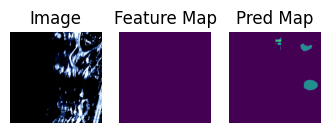

Epoch [72/500], Loss: 0.2070, JaccardIndex: 0.4524


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Validation Loss: 0.2143, Validation JaccardIndex: 0.5821


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


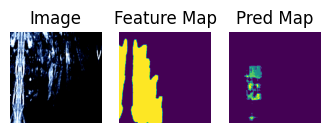

Epoch [73/500], Loss: 0.2127, JaccardIndex: 0.4498


100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Validation Loss: 0.2116, Validation JaccardIndex: 0.4336


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


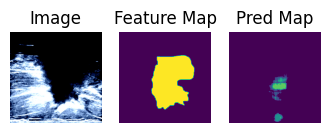

Epoch [74/500], Loss: 0.2059, JaccardIndex: 0.4453


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Validation Loss: 0.2217, Validation JaccardIndex: 0.4471


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


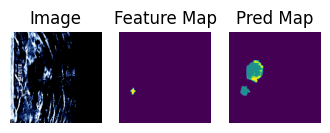

Epoch [75/500], Loss: 0.2095, JaccardIndex: 0.4429


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Validation Loss: 0.2024, Validation JaccardIndex: 0.4242


100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


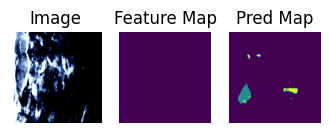

Epoch [76/500], Loss: 0.2070, JaccardIndex: 0.4670


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Validation Loss: 0.1972, Validation JaccardIndex: 0.4501


100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


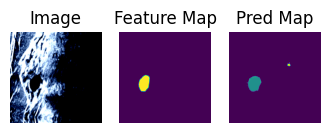

Epoch [77/500], Loss: 0.2050, JaccardIndex: 0.4685


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Validation Loss: 0.2021, Validation JaccardIndex: 0.4220


100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


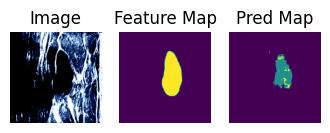

Epoch [78/500], Loss: 0.2070, JaccardIndex: 0.4637


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Validation Loss: 0.2041, Validation JaccardIndex: 0.4385


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


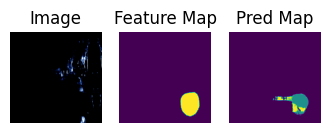

Epoch [79/500], Loss: 0.2076, JaccardIndex: 0.4578


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Validation Loss: 0.1950, Validation JaccardIndex: 0.4787


100%|██████████| 78/78 [00:23<00:00,  3.25it/s]


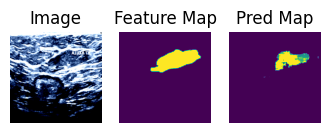

Epoch [80/500], Loss: 0.2116, JaccardIndex: 0.4531


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Validation Loss: 0.1998, Validation JaccardIndex: 0.4125


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


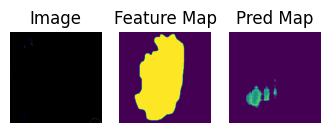

Epoch [81/500], Loss: 0.2088, JaccardIndex: 0.4607


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Validation Loss: 0.2032, Validation JaccardIndex: 0.4815


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


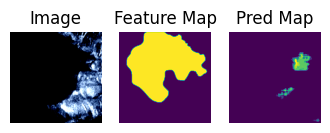

Epoch [82/500], Loss: 0.2060, JaccardIndex: 0.4552


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Validation Loss: 0.2080, Validation JaccardIndex: 0.4161


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


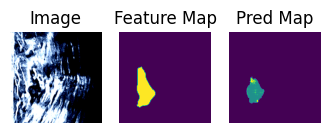

Epoch [83/500], Loss: 0.2111, JaccardIndex: 0.4532


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Validation Loss: 0.2078, Validation JaccardIndex: 0.4327


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


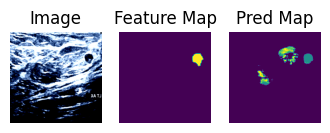

Epoch [84/500], Loss: 0.2059, JaccardIndex: 0.4642


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Validation Loss: 0.2094, Validation JaccardIndex: 0.4852


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


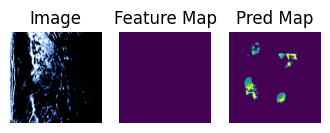

Epoch [85/500], Loss: 0.2017, JaccardIndex: 0.4594


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Validation Loss: 0.2160, Validation JaccardIndex: 0.4452


100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


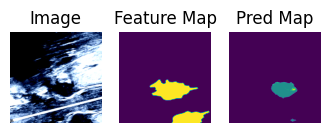

Epoch [86/500], Loss: 0.2034, JaccardIndex: 0.4750


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Validation Loss: 0.1970, Validation JaccardIndex: 0.4821


100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


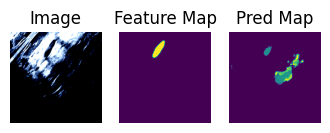

Epoch [87/500], Loss: 0.2057, JaccardIndex: 0.4565


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Validation Loss: 0.2089, Validation JaccardIndex: 0.4228


100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


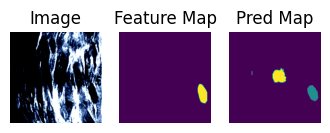

Epoch [88/500], Loss: 0.2035, JaccardIndex: 0.4648


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Validation Loss: 0.2130, Validation JaccardIndex: 0.4740


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


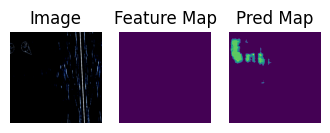

Epoch [89/500], Loss: 0.1953, JaccardIndex: 0.4690


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]

Validation Loss: 0.2195, Validation JaccardIndex: 0.4143
Early stopping


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# early stopping 
patience = 10
best_val_loss = np.inf
counter = 0


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_accuracy = 0.0
    
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device), torch.squeeze(targets.to(device), dim=1)
        
        outputs = model(images)
        loss = criterion(outputs, targets.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # JaccardIndex for segmentation
        _, preds = torch.max(outputs.data, 1)
        train_accuracy += JaccardIndex(task="multiclass", num_classes=3)(preds.cpu(), targets.cpu())
    with torch.no_grad():
        for images, targets in train_loader:
            images, targets = images.to(device)[0], torch.squeeze(targets.to(device), dim=1)
            outputs = torch.argmax(model(images[None]), dim=1)
            plot_image_feature_preds(images.cpu(), targets.cpu(), outputs.cpu())
            # visualize the feature map
            break

    train_accuracy /= len(train_loader)
    train_loss = running_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, JaccardIndex: {train_accuracy:.4f}')
    
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images, targets = images.to(device), torch.squeeze(targets.to(device), dim=1)
            outputs = model(images)
            loss = criterion(outputs, targets.long())
            val_loss += loss.item()
            
            
            _, preds = torch.max(outputs.data, 1)
            val_accuracy += JaccardIndex(task="multiclass", num_classes=3)(preds.cpu(), targets.cpu())

    val_loss = val_loss / len(val_loader)
    val_accuracy /= len(val_loader)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation JaccardIndex: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
torch.save(model.state_dict(), 'seg_model_1.pth')

In [ ]:
# decent results, but not great. The data is noisy and complex while the model is relatively simple

In [16]:
# Model 2 method: Classification + Segmentation so segmentation is done based on the classification model

In [17]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        image = np.array(image)
        mask = np.array(mask)

        # binary masking for segmentaiton
        class_name = os.path.basename(os.path.dirname(self.image_paths[idx]))
        if class_name != 'normal':
            mask[mask > 0] = 1
        elif class_name == 'normal':
            mask[mask > 0] = 0
        

        # class types for classificaiton
        if class_name == 'normal':
            class_type = 0
        elif class_name == 'benign':
            class_type = 1
        elif class_name == 'malignant':
            class_type = 2
            
            
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, (mask, class_type)


fold_idx = 0
batch_size = 8
train_loader, val_loader = create_dataloaders(image_paths, mask_paths, splits, fold_idx, transform, batch_size)


In [18]:
class seg_model(nn.Module):
    def __init__(self):
        super(seg_model, self).__init__()
        self.enc = nn.ModuleList([
            BottleNeck(3, 16, 16, True), 
            BottleNeck(16, 24, 32, True), 
            BottleNeck(24, 48, 64, True),
            BottleNeck(48, 96, 128, True),
            BottleNeck(96, 192, 256, True)
        ])
        self.mid_layer = nn.Sequential(BottleNeck(192, 192, 256), BottleNeck(192, 192, 256))
        self.dec = nn.ModuleList([
            BottleNeck(192 + 192, 96, 256, False),
            BottleNeck(96 + 96, 48, 128, False),
            BottleNeck(48 + 48, 24, 64, False),
            BottleNeck(24 + 24, 16, 32, False),
            BottleNeck(16 + 16, 3, 16, False),
        ])
        self.to_logits = BottleNeck(3, 2, 8, no_sample=True)

        # classifier model
        self.classifier = nn.Sequential(
            BottleNeck(3, 16, 16, True), 
            BottleNeck(16, 24, 32, True), 
            BottleNeck(24, 48, 64, True),
            BottleNeck(48, 96, 128, True),
            BottleNeck(96, 192, 256, True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(192, 3)
        )

    def forward(self, x):
        class_output = self.classifier(x)
        enc_outputs = []
        for layer in self.enc:
            x = layer(x)
            enc_outputs.append(x)
        x = self.mid_layer(x)
        for i, layer in enumerate(self.dec):
            x = torch.cat((x, enc_outputs[len(enc_outputs) - i - 1]), dim=1)
            x = layer(x)
        seg_output = self.to_logits(x) 
        return seg_output, class_output

4899266


100%|██████████| 78/78 [00:36<00:00,  2.17it/s]


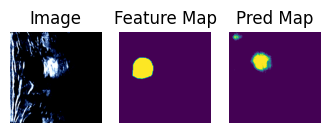

Epoch [1/500], Segmentation Loss: 0.6628, Classification Loss: 0.9930, Segmentation Jaccard Index: 0.4047, Multiplied Jaccard Index: 0.2793, Classification Accuracy: 0.5529


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Validation Segmentation Loss: 0.6217, Validation Classification Loss: 0.9844, Validation Segmentation Jaccard Index: 0.5177, Multiplied Jaccard Index: 0.4546, Validation Classification Accuracy: 0.5125


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


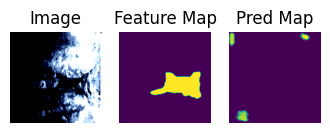

Epoch [2/500], Segmentation Loss: 0.6030, Classification Loss: 0.9656, Segmentation Jaccard Index: 0.4854, Multiplied Jaccard Index: 0.3362, Classification Accuracy: 0.5593


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.6696, Validation Classification Loss: 1.1147, Validation Segmentation Jaccard Index: 0.4338, Multiplied Jaccard Index: 0.2822, Validation Classification Accuracy: 0.4750


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


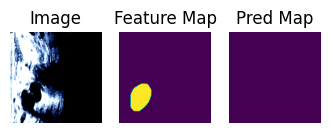

Epoch [3/500], Segmentation Loss: 0.5540, Classification Loss: 0.9477, Segmentation Jaccard Index: 0.4602, Multiplied Jaccard Index: 0.3125, Classification Accuracy: 0.5865


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Validation Segmentation Loss: 0.5316, Validation Classification Loss: 1.0051, Validation Segmentation Jaccard Index: 0.5335, Multiplied Jaccard Index: 0.5335, Validation Classification Accuracy: 0.5312


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


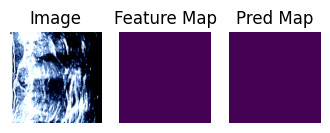

Epoch [4/500], Segmentation Loss: 0.5104, Classification Loss: 0.9500, Segmentation Jaccard Index: 0.4612, Multiplied Jaccard Index: 0.3177, Classification Accuracy: 0.5657


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Validation Segmentation Loss: 0.4986, Validation Classification Loss: 0.9350, Validation Segmentation Jaccard Index: 0.5330, Multiplied Jaccard Index: 0.5330, Validation Classification Accuracy: 0.6125


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


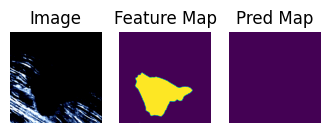

Epoch [5/500], Segmentation Loss: 0.4743, Classification Loss: 0.9321, Segmentation Jaccard Index: 0.4608, Multiplied Jaccard Index: 0.3236, Classification Accuracy: 0.5897


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.4645, Validation Classification Loss: 0.9827, Validation Segmentation Jaccard Index: 0.5324, Multiplied Jaccard Index: 0.5324, Validation Classification Accuracy: 0.5125


100%|██████████| 78/78 [00:35<00:00,  2.19it/s]


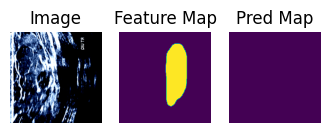

Epoch [6/500], Segmentation Loss: 0.4430, Classification Loss: 0.9538, Segmentation Jaccard Index: 0.4607, Multiplied Jaccard Index: 0.3214, Classification Accuracy: 0.5705


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Validation Segmentation Loss: 0.4456, Validation Classification Loss: 0.9513, Validation Segmentation Jaccard Index: 0.5328, Multiplied Jaccard Index: 0.5328, Validation Classification Accuracy: 0.5875


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


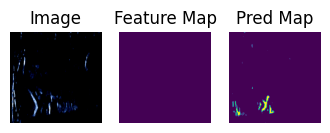

Epoch [7/500], Segmentation Loss: 0.4134, Classification Loss: 0.9388, Segmentation Jaccard Index: 0.4697, Multiplied Jaccard Index: 0.3256, Classification Accuracy: 0.5849


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Validation Segmentation Loss: 0.8546, Validation Classification Loss: 0.9536, Validation Segmentation Jaccard Index: 0.2957, Multiplied Jaccard Index: 0.2221, Validation Classification Accuracy: 0.5625


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


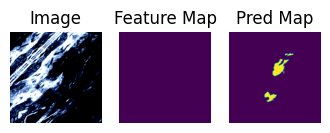

Epoch [8/500], Segmentation Loss: 0.3797, Classification Loss: 0.9185, Segmentation Jaccard Index: 0.5374, Multiplied Jaccard Index: 0.3736, Classification Accuracy: 0.6074


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Validation Segmentation Loss: 0.3679, Validation Classification Loss: 0.9054, Validation Segmentation Jaccard Index: 0.5288, Multiplied Jaccard Index: 0.4328, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


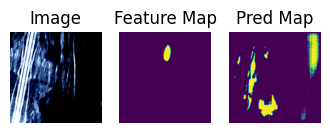

Epoch [9/500], Segmentation Loss: 0.3485, Classification Loss: 0.9143, Segmentation Jaccard Index: 0.5688, Multiplied Jaccard Index: 0.4057, Classification Accuracy: 0.6026


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Validation Segmentation Loss: 0.3824, Validation Classification Loss: 0.9475, Validation Segmentation Jaccard Index: 0.5333, Multiplied Jaccard Index: 0.4081, Validation Classification Accuracy: 0.5813


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


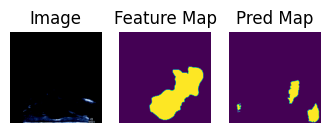

Epoch [10/500], Segmentation Loss: 0.3309, Classification Loss: 0.9180, Segmentation Jaccard Index: 0.5774, Multiplied Jaccard Index: 0.4032, Classification Accuracy: 0.5881


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Validation Segmentation Loss: 0.3325, Validation Classification Loss: 0.9762, Validation Segmentation Jaccard Index: 0.5843, Multiplied Jaccard Index: 0.4069, Validation Classification Accuracy: 0.5750


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


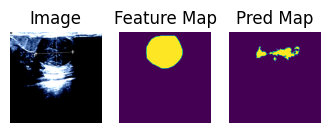

Epoch [11/500], Segmentation Loss: 0.3098, Classification Loss: 0.9196, Segmentation Jaccard Index: 0.5975, Multiplied Jaccard Index: 0.4364, Classification Accuracy: 0.6026


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Validation Segmentation Loss: 0.2935, Validation Classification Loss: 0.9308, Validation Segmentation Jaccard Index: 0.6018, Multiplied Jaccard Index: 0.5165, Validation Classification Accuracy: 0.5938


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


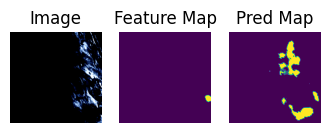

Epoch [12/500], Segmentation Loss: 0.2945, Classification Loss: 0.9060, Segmentation Jaccard Index: 0.5933, Multiplied Jaccard Index: 0.4238, Classification Accuracy: 0.6202


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Validation Segmentation Loss: 0.3867, Validation Classification Loss: 0.9161, Validation Segmentation Jaccard Index: 0.5557, Multiplied Jaccard Index: 0.4258, Validation Classification Accuracy: 0.6313


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


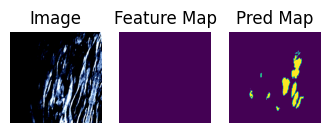

Epoch [13/500], Segmentation Loss: 0.2833, Classification Loss: 0.9207, Segmentation Jaccard Index: 0.5974, Multiplied Jaccard Index: 0.4251, Classification Accuracy: 0.5929


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


Validation Segmentation Loss: 0.3314, Validation Classification Loss: 0.8861, Validation Segmentation Jaccard Index: 0.5578, Multiplied Jaccard Index: 0.4650, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


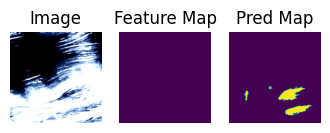

Epoch [14/500], Segmentation Loss: 0.2719, Classification Loss: 0.9099, Segmentation Jaccard Index: 0.6020, Multiplied Jaccard Index: 0.4386, Classification Accuracy: 0.6218


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Validation Segmentation Loss: 0.2937, Validation Classification Loss: 1.0365, Validation Segmentation Jaccard Index: 0.5863, Multiplied Jaccard Index: 0.5115, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


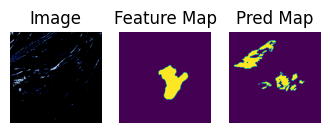

Epoch [15/500], Segmentation Loss: 0.2574, Classification Loss: 0.9050, Segmentation Jaccard Index: 0.6152, Multiplied Jaccard Index: 0.4477, Classification Accuracy: 0.6042


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Validation Segmentation Loss: 0.2487, Validation Classification Loss: 0.9490, Validation Segmentation Jaccard Index: 0.6066, Multiplied Jaccard Index: 0.4030, Validation Classification Accuracy: 0.5688


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


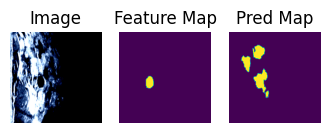

Epoch [16/500], Segmentation Loss: 0.2488, Classification Loss: 0.8769, Segmentation Jaccard Index: 0.6122, Multiplied Jaccard Index: 0.4404, Classification Accuracy: 0.6170


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Validation Segmentation Loss: 0.2599, Validation Classification Loss: 0.9193, Validation Segmentation Jaccard Index: 0.6085, Multiplied Jaccard Index: 0.4399, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


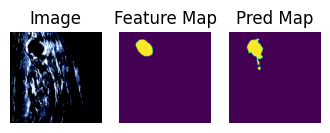

Epoch [17/500], Segmentation Loss: 0.2469, Classification Loss: 0.9034, Segmentation Jaccard Index: 0.5966, Multiplied Jaccard Index: 0.4246, Classification Accuracy: 0.5929


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Validation Segmentation Loss: 0.2322, Validation Classification Loss: 0.9187, Validation Segmentation Jaccard Index: 0.6464, Multiplied Jaccard Index: 0.4552, Validation Classification Accuracy: 0.5813


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


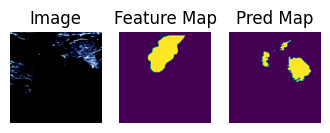

Epoch [18/500], Segmentation Loss: 0.2386, Classification Loss: 0.9446, Segmentation Jaccard Index: 0.6157, Multiplied Jaccard Index: 0.4437, Classification Accuracy: 0.5833


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Validation Segmentation Loss: 0.2853, Validation Classification Loss: 0.9728, Validation Segmentation Jaccard Index: 0.5981, Multiplied Jaccard Index: 0.3815, Validation Classification Accuracy: 0.5688


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


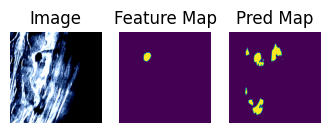

Epoch [19/500], Segmentation Loss: 0.2327, Classification Loss: 0.9154, Segmentation Jaccard Index: 0.6125, Multiplied Jaccard Index: 0.4294, Classification Accuracy: 0.5978


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Validation Segmentation Loss: 0.2282, Validation Classification Loss: 0.9214, Validation Segmentation Jaccard Index: 0.6123, Multiplied Jaccard Index: 0.4543, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


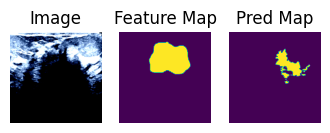

Epoch [20/500], Segmentation Loss: 0.2280, Classification Loss: 0.9178, Segmentation Jaccard Index: 0.6134, Multiplied Jaccard Index: 0.4301, Classification Accuracy: 0.5929


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Validation Segmentation Loss: 0.2174, Validation Classification Loss: 0.9180, Validation Segmentation Jaccard Index: 0.6316, Multiplied Jaccard Index: 0.4872, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


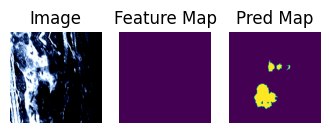

Epoch [21/500], Segmentation Loss: 0.2191, Classification Loss: 0.9041, Segmentation Jaccard Index: 0.6273, Multiplied Jaccard Index: 0.4505, Classification Accuracy: 0.5994


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Validation Segmentation Loss: 0.2228, Validation Classification Loss: 0.9253, Validation Segmentation Jaccard Index: 0.6167, Multiplied Jaccard Index: 0.5252, Validation Classification Accuracy: 0.5875


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


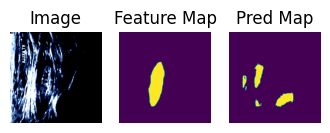

Epoch [22/500], Segmentation Loss: 0.2198, Classification Loss: 0.9132, Segmentation Jaccard Index: 0.6083, Multiplied Jaccard Index: 0.4336, Classification Accuracy: 0.6010


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Validation Segmentation Loss: 0.2658, Validation Classification Loss: 0.9230, Validation Segmentation Jaccard Index: 0.6085, Multiplied Jaccard Index: 0.4534, Validation Classification Accuracy: 0.5625


100%|██████████| 78/78 [00:35<00:00,  2.19it/s]


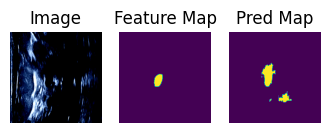

Epoch [23/500], Segmentation Loss: 0.2165, Classification Loss: 0.9046, Segmentation Jaccard Index: 0.6211, Multiplied Jaccard Index: 0.4553, Classification Accuracy: 0.6074


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Validation Segmentation Loss: 0.2257, Validation Classification Loss: 1.1519, Validation Segmentation Jaccard Index: 0.6418, Multiplied Jaccard Index: 0.4894, Validation Classification Accuracy: 0.4875


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


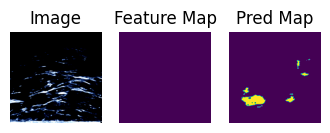

Epoch [24/500], Segmentation Loss: 0.2128, Classification Loss: 0.9482, Segmentation Jaccard Index: 0.6143, Multiplied Jaccard Index: 0.4163, Classification Accuracy: 0.5641


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Validation Segmentation Loss: 0.2121, Validation Classification Loss: 0.8958, Validation Segmentation Jaccard Index: 0.6352, Multiplied Jaccard Index: 0.5519, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


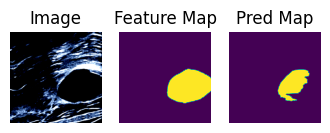

Epoch [25/500], Segmentation Loss: 0.2090, Classification Loss: 0.9326, Segmentation Jaccard Index: 0.6199, Multiplied Jaccard Index: 0.4199, Classification Accuracy: 0.5561


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Validation Segmentation Loss: 0.2063, Validation Classification Loss: 0.9224, Validation Segmentation Jaccard Index: 0.6274, Multiplied Jaccard Index: 0.5299, Validation Classification Accuracy: 0.6125


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


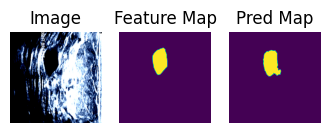

Epoch [26/500], Segmentation Loss: 0.2038, Classification Loss: 0.9202, Segmentation Jaccard Index: 0.6303, Multiplied Jaccard Index: 0.4548, Classification Accuracy: 0.6010


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Validation Segmentation Loss: 0.2042, Validation Classification Loss: 0.9639, Validation Segmentation Jaccard Index: 0.6254, Multiplied Jaccard Index: 0.5174, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


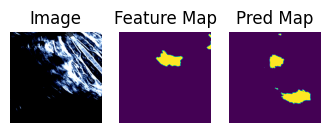

Epoch [27/500], Segmentation Loss: 0.2015, Classification Loss: 0.9185, Segmentation Jaccard Index: 0.6250, Multiplied Jaccard Index: 0.4320, Classification Accuracy: 0.5753


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Validation Segmentation Loss: 0.2296, Validation Classification Loss: 1.0327, Validation Segmentation Jaccard Index: 0.6116, Multiplied Jaccard Index: 0.4576, Validation Classification Accuracy: 0.5125


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


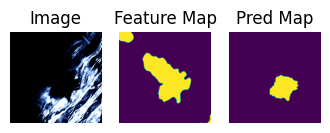

Epoch [28/500], Segmentation Loss: 0.2015, Classification Loss: 0.9056, Segmentation Jaccard Index: 0.6241, Multiplied Jaccard Index: 0.4490, Classification Accuracy: 0.5978


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.1926, Validation Classification Loss: 0.8941, Validation Segmentation Jaccard Index: 0.6394, Multiplied Jaccard Index: 0.5229, Validation Classification Accuracy: 0.5437


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


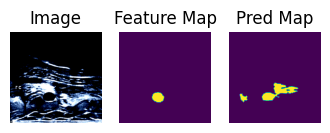

Epoch [29/500], Segmentation Loss: 0.1970, Classification Loss: 0.9158, Segmentation Jaccard Index: 0.6274, Multiplied Jaccard Index: 0.4321, Classification Accuracy: 0.5849


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Validation Segmentation Loss: 0.1863, Validation Classification Loss: 0.9533, Validation Segmentation Jaccard Index: 0.6332, Multiplied Jaccard Index: 0.4855, Validation Classification Accuracy: 0.6187


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


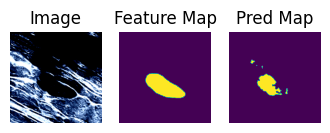

Epoch [30/500], Segmentation Loss: 0.1975, Classification Loss: 0.9174, Segmentation Jaccard Index: 0.6298, Multiplied Jaccard Index: 0.4510, Classification Accuracy: 0.6090


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Validation Segmentation Loss: 0.1950, Validation Classification Loss: 0.9155, Validation Segmentation Jaccard Index: 0.6494, Multiplied Jaccard Index: 0.5005, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


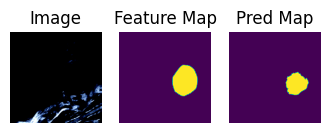

Epoch [31/500], Segmentation Loss: 0.1993, Classification Loss: 0.8976, Segmentation Jaccard Index: 0.6234, Multiplied Jaccard Index: 0.4489, Classification Accuracy: 0.6234


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Validation Segmentation Loss: 0.1975, Validation Classification Loss: 0.9847, Validation Segmentation Jaccard Index: 0.6600, Multiplied Jaccard Index: 0.5296, Validation Classification Accuracy: 0.5375


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


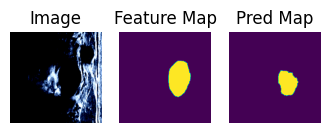

Epoch [32/500], Segmentation Loss: 0.1955, Classification Loss: 0.9059, Segmentation Jaccard Index: 0.6269, Multiplied Jaccard Index: 0.4571, Classification Accuracy: 0.5994


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.1925, Validation Classification Loss: 0.9089, Validation Segmentation Jaccard Index: 0.6439, Multiplied Jaccard Index: 0.5102, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


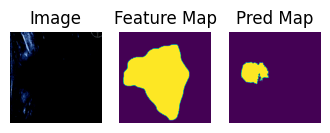

Epoch [33/500], Segmentation Loss: 0.1908, Classification Loss: 0.9110, Segmentation Jaccard Index: 0.6312, Multiplied Jaccard Index: 0.4422, Classification Accuracy: 0.5962


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Validation Segmentation Loss: 0.1861, Validation Classification Loss: 0.9136, Validation Segmentation Jaccard Index: 0.6484, Multiplied Jaccard Index: 0.5003, Validation Classification Accuracy: 0.5875


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


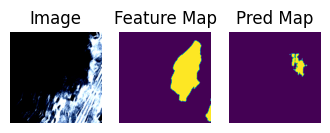

Epoch [34/500], Segmentation Loss: 0.1909, Classification Loss: 0.8875, Segmentation Jaccard Index: 0.6361, Multiplied Jaccard Index: 0.4585, Classification Accuracy: 0.6122


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Validation Segmentation Loss: 0.1851, Validation Classification Loss: 0.9571, Validation Segmentation Jaccard Index: 0.6265, Multiplied Jaccard Index: 0.4043, Validation Classification Accuracy: 0.5437


100%|██████████| 78/78 [00:37<00:00,  2.09it/s]


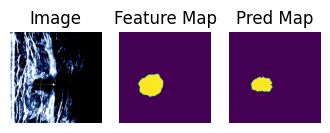

Epoch [35/500], Segmentation Loss: 0.1894, Classification Loss: 0.8893, Segmentation Jaccard Index: 0.6284, Multiplied Jaccard Index: 0.4456, Classification Accuracy: 0.5978


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Validation Segmentation Loss: 0.2005, Validation Classification Loss: 0.9947, Validation Segmentation Jaccard Index: 0.6531, Multiplied Jaccard Index: 0.4467, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


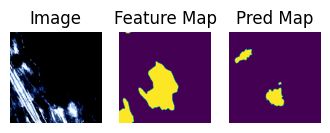

Epoch [36/500], Segmentation Loss: 0.1899, Classification Loss: 0.8727, Segmentation Jaccard Index: 0.6268, Multiplied Jaccard Index: 0.4562, Classification Accuracy: 0.6154


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Validation Segmentation Loss: 0.1805, Validation Classification Loss: 0.9751, Validation Segmentation Jaccard Index: 0.6315, Multiplied Jaccard Index: 0.4139, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


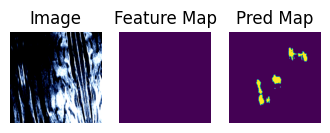

Epoch [37/500], Segmentation Loss: 0.1901, Classification Loss: 0.8823, Segmentation Jaccard Index: 0.6232, Multiplied Jaccard Index: 0.4622, Classification Accuracy: 0.6138


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Validation Segmentation Loss: 0.1868, Validation Classification Loss: 0.9194, Validation Segmentation Jaccard Index: 0.6364, Multiplied Jaccard Index: 0.4940, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


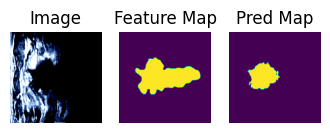

Epoch [38/500], Segmentation Loss: 0.1841, Classification Loss: 0.8763, Segmentation Jaccard Index: 0.6408, Multiplied Jaccard Index: 0.4737, Classification Accuracy: 0.6250


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Validation Segmentation Loss: 0.1764, Validation Classification Loss: 0.8620, Validation Segmentation Jaccard Index: 0.6368, Multiplied Jaccard Index: 0.5278, Validation Classification Accuracy: 0.6250


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


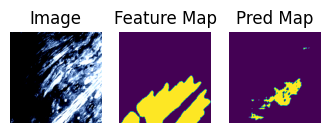

Epoch [39/500], Segmentation Loss: 0.1853, Classification Loss: 0.8705, Segmentation Jaccard Index: 0.6304, Multiplied Jaccard Index: 0.4418, Classification Accuracy: 0.6074


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Validation Segmentation Loss: 0.1728, Validation Classification Loss: 0.9403, Validation Segmentation Jaccard Index: 0.6633, Multiplied Jaccard Index: 0.4434, Validation Classification Accuracy: 0.5750


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


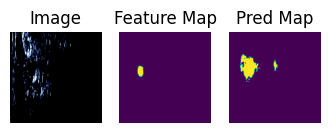

Epoch [40/500], Segmentation Loss: 0.1821, Classification Loss: 0.9015, Segmentation Jaccard Index: 0.6406, Multiplied Jaccard Index: 0.4653, Classification Accuracy: 0.6026


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.1721, Validation Classification Loss: 1.0325, Validation Segmentation Jaccard Index: 0.6699, Multiplied Jaccard Index: 0.4690, Validation Classification Accuracy: 0.4875


100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


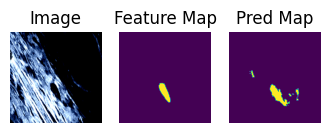

Epoch [41/500], Segmentation Loss: 0.1871, Classification Loss: 0.8814, Segmentation Jaccard Index: 0.6252, Multiplied Jaccard Index: 0.4610, Classification Accuracy: 0.6186


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Validation Segmentation Loss: 0.1937, Validation Classification Loss: 0.9174, Validation Segmentation Jaccard Index: 0.6642, Multiplied Jaccard Index: 0.5291, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


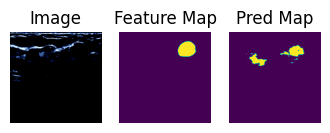

Epoch [42/500], Segmentation Loss: 0.1809, Classification Loss: 0.9166, Segmentation Jaccard Index: 0.6375, Multiplied Jaccard Index: 0.4462, Classification Accuracy: 0.6026


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.2016, Validation Classification Loss: 0.9268, Validation Segmentation Jaccard Index: 0.6312, Multiplied Jaccard Index: 0.5116, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


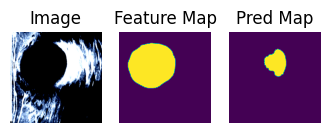

Epoch [43/500], Segmentation Loss: 0.1811, Classification Loss: 0.8827, Segmentation Jaccard Index: 0.6374, Multiplied Jaccard Index: 0.4449, Classification Accuracy: 0.6058


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Validation Segmentation Loss: 0.1778, Validation Classification Loss: 0.9445, Validation Segmentation Jaccard Index: 0.6601, Multiplied Jaccard Index: 0.5482, Validation Classification Accuracy: 0.5500


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


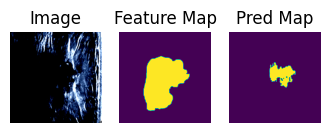

Epoch [44/500], Segmentation Loss: 0.1824, Classification Loss: 0.8930, Segmentation Jaccard Index: 0.6418, Multiplied Jaccard Index: 0.4602, Classification Accuracy: 0.5865


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Validation Segmentation Loss: 0.1706, Validation Classification Loss: 0.8509, Validation Segmentation Jaccard Index: 0.6706, Multiplied Jaccard Index: 0.5416, Validation Classification Accuracy: 0.6250


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


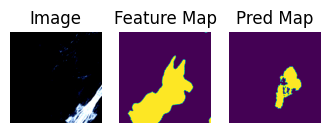

Epoch [45/500], Segmentation Loss: 0.1800, Classification Loss: 0.8883, Segmentation Jaccard Index: 0.6402, Multiplied Jaccard Index: 0.4614, Classification Accuracy: 0.6154


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Validation Segmentation Loss: 0.1783, Validation Classification Loss: 1.0380, Validation Segmentation Jaccard Index: 0.6402, Multiplied Jaccard Index: 0.5228, Validation Classification Accuracy: 0.5562


100%|██████████| 78/78 [00:37<00:00,  2.11it/s]


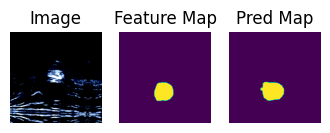

Epoch [46/500], Segmentation Loss: 0.1825, Classification Loss: 0.9015, Segmentation Jaccard Index: 0.6314, Multiplied Jaccard Index: 0.4569, Classification Accuracy: 0.5994


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Validation Segmentation Loss: 0.1899, Validation Classification Loss: 0.8913, Validation Segmentation Jaccard Index: 0.6565, Multiplied Jaccard Index: 0.5279, Validation Classification Accuracy: 0.6313


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


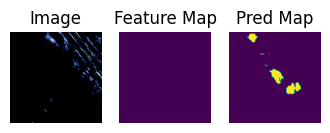

Epoch [47/500], Segmentation Loss: 0.1782, Classification Loss: 0.8712, Segmentation Jaccard Index: 0.6369, Multiplied Jaccard Index: 0.4800, Classification Accuracy: 0.6346


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Validation Segmentation Loss: 0.2114, Validation Classification Loss: 0.9008, Validation Segmentation Jaccard Index: 0.6299, Multiplied Jaccard Index: 0.4238, Validation Classification Accuracy: 0.5750


100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


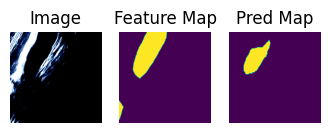

Epoch [48/500], Segmentation Loss: 0.1773, Classification Loss: 0.8888, Segmentation Jaccard Index: 0.6425, Multiplied Jaccard Index: 0.4552, Classification Accuracy: 0.5978


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Validation Segmentation Loss: 0.1752, Validation Classification Loss: 1.0874, Validation Segmentation Jaccard Index: 0.6477, Multiplied Jaccard Index: 0.4373, Validation Classification Accuracy: 0.3938


100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


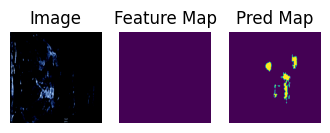

Epoch [49/500], Segmentation Loss: 0.1809, Classification Loss: 0.8570, Segmentation Jaccard Index: 0.6438, Multiplied Jaccard Index: 0.4666, Classification Accuracy: 0.6314


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Validation Segmentation Loss: 0.1950, Validation Classification Loss: 0.9945, Validation Segmentation Jaccard Index: 0.6351, Multiplied Jaccard Index: 0.5240, Validation Classification Accuracy: 0.6000


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


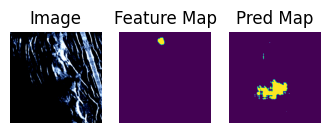

Epoch [50/500], Segmentation Loss: 0.1788, Classification Loss: 0.8584, Segmentation Jaccard Index: 0.6449, Multiplied Jaccard Index: 0.4751, Classification Accuracy: 0.6186


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.1767, Validation Classification Loss: 0.8616, Validation Segmentation Jaccard Index: 0.6511, Multiplied Jaccard Index: 0.4984, Validation Classification Accuracy: 0.6500


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


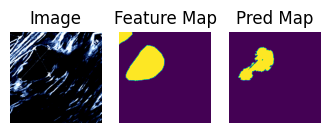

Epoch [51/500], Segmentation Loss: 0.1778, Classification Loss: 0.8706, Segmentation Jaccard Index: 0.6374, Multiplied Jaccard Index: 0.4709, Classification Accuracy: 0.6218


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Validation Segmentation Loss: 0.1687, Validation Classification Loss: 0.8957, Validation Segmentation Jaccard Index: 0.6566, Multiplied Jaccard Index: 0.4441, Validation Classification Accuracy: 0.6250


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


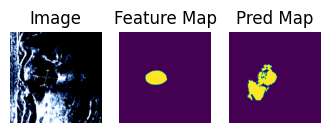

Epoch [52/500], Segmentation Loss: 0.1754, Classification Loss: 0.8910, Segmentation Jaccard Index: 0.6379, Multiplied Jaccard Index: 0.4617, Classification Accuracy: 0.5913


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Validation Segmentation Loss: 0.1873, Validation Classification Loss: 0.8834, Validation Segmentation Jaccard Index: 0.6374, Multiplied Jaccard Index: 0.4472, Validation Classification Accuracy: 0.6250


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


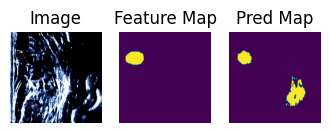

Epoch [53/500], Segmentation Loss: 0.1731, Classification Loss: 0.8590, Segmentation Jaccard Index: 0.6549, Multiplied Jaccard Index: 0.4770, Classification Accuracy: 0.6330


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Validation Segmentation Loss: 0.1728, Validation Classification Loss: 0.8354, Validation Segmentation Jaccard Index: 0.6442, Multiplied Jaccard Index: 0.4550, Validation Classification Accuracy: 0.6438


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


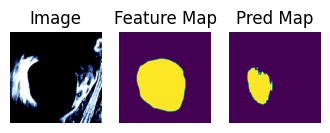

Epoch [54/500], Segmentation Loss: 0.1773, Classification Loss: 0.8584, Segmentation Jaccard Index: 0.6393, Multiplied Jaccard Index: 0.4600, Classification Accuracy: 0.6170


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Validation Segmentation Loss: 0.1701, Validation Classification Loss: 0.9087, Validation Segmentation Jaccard Index: 0.6858, Multiplied Jaccard Index: 0.4860, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


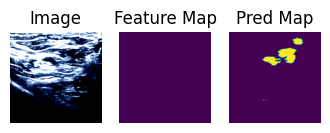

Epoch [55/500], Segmentation Loss: 0.1731, Classification Loss: 0.9029, Segmentation Jaccard Index: 0.6527, Multiplied Jaccard Index: 0.4665, Classification Accuracy: 0.6122


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Validation Segmentation Loss: 0.1659, Validation Classification Loss: 0.8721, Validation Segmentation Jaccard Index: 0.6663, Multiplied Jaccard Index: 0.4974, Validation Classification Accuracy: 0.6562


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


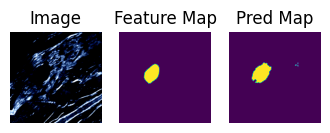

Epoch [56/500], Segmentation Loss: 0.1722, Classification Loss: 0.8781, Segmentation Jaccard Index: 0.6492, Multiplied Jaccard Index: 0.4640, Classification Accuracy: 0.6202


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Validation Segmentation Loss: 0.1597, Validation Classification Loss: 0.8447, Validation Segmentation Jaccard Index: 0.6463, Multiplied Jaccard Index: 0.5150, Validation Classification Accuracy: 0.6500


100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


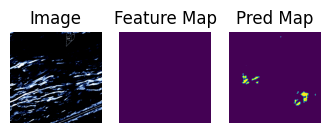

Epoch [57/500], Segmentation Loss: 0.1803, Classification Loss: 0.8694, Segmentation Jaccard Index: 0.6318, Multiplied Jaccard Index: 0.4722, Classification Accuracy: 0.6186


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Validation Segmentation Loss: 0.1946, Validation Classification Loss: 0.9459, Validation Segmentation Jaccard Index: 0.6703, Multiplied Jaccard Index: 0.5668, Validation Classification Accuracy: 0.6062


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


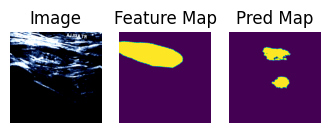

Epoch [58/500], Segmentation Loss: 0.1750, Classification Loss: 0.8600, Segmentation Jaccard Index: 0.6492, Multiplied Jaccard Index: 0.4692, Classification Accuracy: 0.6122


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Validation Segmentation Loss: 0.1664, Validation Classification Loss: 0.9176, Validation Segmentation Jaccard Index: 0.7061, Multiplied Jaccard Index: 0.4633, Validation Classification Accuracy: 0.5250


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


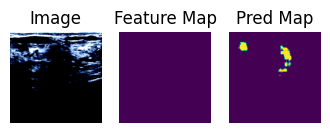

Epoch [59/500], Segmentation Loss: 0.1692, Classification Loss: 0.8646, Segmentation Jaccard Index: 0.6528, Multiplied Jaccard Index: 0.4765, Classification Accuracy: 0.6138


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Validation Segmentation Loss: 0.1593, Validation Classification Loss: 0.9203, Validation Segmentation Jaccard Index: 0.6917, Multiplied Jaccard Index: 0.4952, Validation Classification Accuracy: 0.5625


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


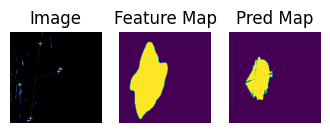

Epoch [60/500], Segmentation Loss: 0.1674, Classification Loss: 0.8239, Segmentation Jaccard Index: 0.6664, Multiplied Jaccard Index: 0.4894, Classification Accuracy: 0.6538


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Validation Segmentation Loss: 0.1618, Validation Classification Loss: 0.9059, Validation Segmentation Jaccard Index: 0.6741, Multiplied Jaccard Index: 0.5078, Validation Classification Accuracy: 0.5688


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


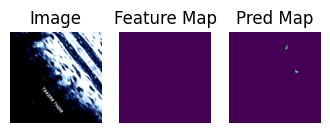

Epoch [61/500], Segmentation Loss: 0.1731, Classification Loss: 0.8266, Segmentation Jaccard Index: 0.6472, Multiplied Jaccard Index: 0.4737, Classification Accuracy: 0.6346


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Validation Segmentation Loss: 0.1685, Validation Classification Loss: 0.8647, Validation Segmentation Jaccard Index: 0.6750, Multiplied Jaccard Index: 0.4872, Validation Classification Accuracy: 0.5750


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


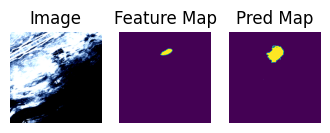

Epoch [62/500], Segmentation Loss: 0.1683, Classification Loss: 0.8515, Segmentation Jaccard Index: 0.6564, Multiplied Jaccard Index: 0.4798, Classification Accuracy: 0.6282


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Validation Segmentation Loss: 0.1862, Validation Classification Loss: 0.8490, Validation Segmentation Jaccard Index: 0.6621, Multiplied Jaccard Index: 0.5049, Validation Classification Accuracy: 0.6375


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


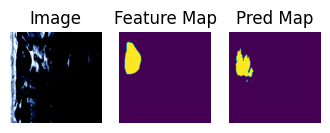

Epoch [63/500], Segmentation Loss: 0.1768, Classification Loss: 0.8532, Segmentation Jaccard Index: 0.6424, Multiplied Jaccard Index: 0.4641, Classification Accuracy: 0.6138


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Validation Segmentation Loss: 0.1717, Validation Classification Loss: 0.8646, Validation Segmentation Jaccard Index: 0.6435, Multiplied Jaccard Index: 0.4944, Validation Classification Accuracy: 0.6125


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


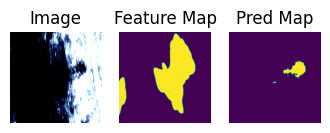

Epoch [64/500], Segmentation Loss: 0.1700, Classification Loss: 0.8680, Segmentation Jaccard Index: 0.6617, Multiplied Jaccard Index: 0.4970, Classification Accuracy: 0.6362


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Validation Segmentation Loss: 0.1633, Validation Classification Loss: 0.8552, Validation Segmentation Jaccard Index: 0.6683, Multiplied Jaccard Index: 0.5493, Validation Classification Accuracy: 0.6250


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


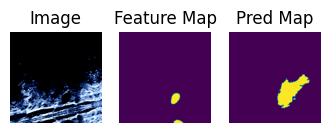

Epoch [65/500], Segmentation Loss: 0.1729, Classification Loss: 0.8507, Segmentation Jaccard Index: 0.6520, Multiplied Jaccard Index: 0.4745, Classification Accuracy: 0.6202


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Validation Segmentation Loss: 0.3037, Validation Classification Loss: 0.9840, Validation Segmentation Jaccard Index: 0.5849, Multiplied Jaccard Index: 0.3988, Validation Classification Accuracy: 0.5125


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


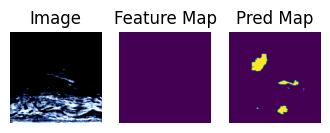

Epoch [66/500], Segmentation Loss: 0.1665, Classification Loss: 0.8338, Segmentation Jaccard Index: 0.6585, Multiplied Jaccard Index: 0.4807, Classification Accuracy: 0.6282


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Validation Segmentation Loss: 0.1711, Validation Classification Loss: 1.0755, Validation Segmentation Jaccard Index: 0.6502, Multiplied Jaccard Index: 0.4066, Validation Classification Accuracy: 0.5063
Early stopping


In [19]:
num_epochs = 500
learning_rate = 0.001

model = seg_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(sum(p.numel() for p in model.parameters()))

segmentation_criterion = nn.CrossEntropyLoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# early stopping
patience = 10
best_val_loss = np.inf
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_segmentation_loss = 0.0
    running_classification_loss = 0.0
    train_seg_accuracy = 0.0
    train_class_accuracy = 0.0
    train_mult_seg_accuracy = 0.0
    
    for images, targets in tqdm(train_loader):
        images, seg_targets, class_targets = images.to(device), torch.squeeze(targets[0].to(device), dim=1), targets[1].to(device)
        
        seg_outputs, class_outputs = model(images)
        seg_loss = segmentation_criterion(seg_outputs, seg_targets.long())
        class_loss = classification_criterion(class_outputs, class_targets.long())
        loss = seg_loss + class_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_segmentation_loss += seg_loss.item()
        running_classification_loss += class_loss.item()
        
        _, seg_preds = torch.max(seg_outputs.data, 1)
        # index for segmentation
        train_seg_accuracy += JaccardIndex(task="multiclass", num_classes=2)(seg_preds.cpu(), seg_targets.cpu())
        # index for segmentation combined with classification
        train_mult_seg_accuracy += JaccardIndex(task="multiclass", num_classes=3)(seg_preds.cpu() * torch.argmax(class_outputs.cpu(),1).view(8, 1, 1), seg_targets.cpu() * class_targets.cpu().view(8,1,1))
        # classification accuracy
        train_class_accuracy += Accuracy(task="multiclass", num_classes=3)(class_outputs.cpu(), class_targets.cpu())
    train_seg_accuracy /= len(train_loader)
    train_class_accuracy /= len(train_loader)
    train_mult_seg_accuracy /= len(train_loader)
    train_segmentation_loss = running_segmentation_loss / len(train_loader)
    train_classification_loss = running_classification_loss / len(train_loader)
    with torch.no_grad():
        for images, targets in train_loader:
            images, targets = images.to(device)[0], torch.squeeze(targets[0].to(device), dim=1)
            outputs = torch.argmax(model(images[None])[0], dim=1)
            plot_image_feature_preds(images.cpu(), targets.cpu(), outputs.cpu())
            break
            
    print(f'Epoch [{epoch+1}/{num_epochs}], Segmentation Loss: {train_segmentation_loss:.4f}, Classification Loss: {train_classification_loss:.4f}, Segmentation Jaccard Index: {train_seg_accuracy:.4f}, Multiplied Jaccard Index: {train_mult_seg_accuracy:.4f}, Classification Accuracy: {train_class_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    val_segmentation_loss = 0.0
    val_classification_loss = 0.0
    val_seg_accuracy = 0.0
    val_class_accuracy = 0.0
    val_mult_seg_accuracy = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images, seg_targets, class_targets = images.to(device), torch.squeeze(targets[0].to(device), dim=1), targets[1].to(device)
            seg_outputs, class_outputs = model(images)
            seg_loss = segmentation_criterion(seg_outputs, seg_targets.long())
            class_loss = classification_criterion(class_outputs, class_targets.long())
            val_segmentation_loss += seg_loss.item()
            val_classification_loss += class_loss.item()
            
            _, seg_preds = torch.max(seg_outputs.data, 1)
            val_seg_accuracy += JaccardIndex(task="multiclass", num_classes=2)(seg_preds.cpu(), seg_targets.cpu())
            val_mult_seg_accuracy += JaccardIndex(task="multiclass", num_classes=3)(seg_preds.cpu() * torch.argmax(class_outputs.cpu(),1).view(len(seg_preds.cpu()),1,1), seg_targets.cpu() * class_targets.cpu().view(len(class_targets.cpu()),1,1))
            val_class_accuracy += Accuracy(task="multiclass", num_classes=3)(class_outputs.cpu(), class_targets.cpu())

    val_segmentation_loss = val_segmentation_loss / len(val_loader)
    val_classification_loss = val_classification_loss / len(val_loader)
    val_mult_seg_accuracy /= len(val_loader)
    val_seg_accuracy /= len(val_loader)
    val_class_accuracy /= len(val_loader)
    
    print(f'Validation Segmentation Loss: {val_segmentation_loss:.4f}, Validation Classification Loss: {val_classification_loss:.4f}, Validation Segmentation Jaccard Index: {val_seg_accuracy:.4f}, Multiplied Jaccard Index: {val_mult_seg_accuracy:.4f}, Validation Classification Accuracy: {val_class_accuracy:.4f}')

    if val_segmentation_loss + val_classification_loss < best_val_loss:
        best_val_loss = val_segmentation_loss + val_classification_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
torch.save(model.state_dict(), 'seg_model_2.pth')